In [72]:
import warnings
warnings.filterwarnings("ignore")
import scipy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima.arima.utils import ndiffs
from math import sqrt
from sklearn.metrics import mean_squared_error
import pandas_datareader as web
import datetime as dt
from pylab import rcParams
import statsmodels.api as sm
from scipy.stats import f
from pandas.plotting import autocorrelation_plot
import seaborn as sns 
import statsmodels.stats.api as sms
from arch.unitroot import ADF
from arch.unitroot import PhillipsPerron
from arch.unitroot import KPSS
import plotly.express as px
from scipy.stats import shapiro
from statsmodels.tsa.seasonal import seasonal_decompose
from pylab import rcParams

In [73]:
start = dt.datetime(2017,1,1)
end = dt.datetime(2021,5,20)
index = '^GDAXI'
data = web.DataReader(index,'yahoo', start, end)
data = data.fillna(method='ffill')
data

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2017-01-02,11617.280273,11414.820312,11426.379883,11598.330078,47456100.0,11598.330078
2017-01-03,11637.370117,11561.230469,11631.700195,11584.240234,88413500.0,11584.240234
2017-01-04,11616.089844,11531.429688,11609.530273,11584.309570,82173600.0,11584.309570
2017-01-05,11602.540039,11537.400391,11537.730469,11584.940430,74924900.0,11584.940430
2017-01-06,11605.740234,11547.049805,11560.519531,11599.009766,67084900.0,11599.009766
...,...,...,...,...,...,...
2021-05-14,15417.240234,15214.679688,15301.740234,15416.639648,69232200.0,15416.639648
2021-05-17,15482.230469,15353.660156,15432.339844,15396.620117,67787000.0,15396.620117
2021-05-18,15538.009766,15344.099609,15514.719727,15386.580078,65843300.0,15386.580078


In [74]:
date_day = dt.datetime(2021,5,21)
actual_day_data = web.DataReader(index,'yahoo', date_day)

In [75]:
last_value = data['Close'].iloc[-1]
last_value

15370.259765625

This notebook contains a trial on predicting the DAX market index closing value, that includes thirty major German companies trading on the Frankfurt Stock Exchange. At first glance, the extracted historical data has a non-stationary behaviour. The ARIMA model will be used and all of the model will be evaluated according to the Box-Jenkins methodology. VAR will also be applied on two Companies taking part in the DAX index, together with a cointegration analysis.

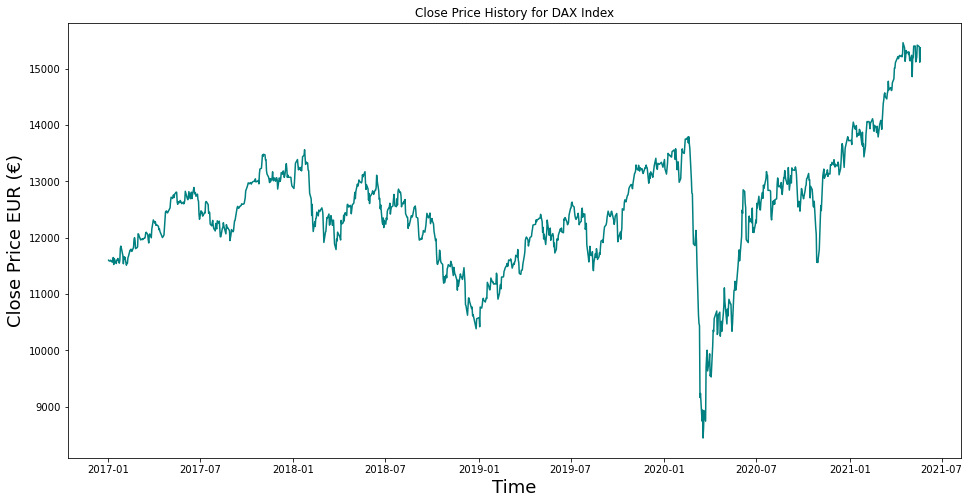

In [76]:
plt.figure(figsize = (16,8))
plt.title('Close Price History for DAX Index')
plt.plot(data['Close'],color="teal")
plt.xlabel('Time', fontsize=18)
plt.ylabel('Close Price EUR (€)', fontsize=18)
plt.show()

# Unit Root Tests
## Augmented Dickey Fuller Test

In [80]:
def ADF_test(series):
    adf = ADF(series)
    adf.lags = 5
    adf.trend = "ct"
    print(adf.summary().as_text())

In [81]:
ADF_test(data['Close'])

   Augmented Dickey-Fuller Results   
Test Statistic                 -2.458
P-value                         0.349
Lags                                5
-------------------------------------

Trend: Constant and Linear Time Trend
Critical Values: -3.97 (1%), -3.41 (5%), -3.13 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


The p-value is much higher than 0.05 for a 5% significance level, as there is not enough evidence to reject the null hypothesis, therefore the process contains a unit root (the series is non-stationary)

## Phillips-Peron Test

In [82]:
def PP_test(series):
    pp = PhillipsPerron(series)
    pp.lags = 12
    pp.trend = "ct"
    print(pp.summary().as_text())

In [83]:
PP_test(data['Close'])

     Phillips-Perron Test (Z-tau)    
Test Statistic                 -2.259
P-value                         0.457
Lags                               12
-------------------------------------

Trend: Constant and Linear Time Trend
Critical Values: -3.97 (1%), -3.41 (5%), -3.13 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


As in the case of the ADF test, the p-value is much higher than 0.05 for a 5% significance level, as there is not enough evidence to reject the null hypothesis, therefore the process contains a unit root (the series is non-stationary).

# Stationarity Test
## KPSS Test

In [84]:
def KPSS_test(series):
    kpss = KPSS(series)
    kpss.trend = "ct"
    print(kpss.summary().as_text())

In [85]:
KPSS_test(data['Close'])

    KPSS Stationarity Test Results   
Test Statistic                  0.491
P-value                         0.000
Lags                               19
-------------------------------------

Trend: Constant and Linear Time Trend
Critical Values: 0.22 (1%), 0.15 (5%), 0.12 (10%)
Null Hypothesis: The process is weakly stationary.
Alternative Hypothesis: The process contains a unit root.


In the case of the KPSS test, the null hypothesis states the contrary of the previous two methods, that the series is stationary. As the p-value is much smaller than 0.05, one has not enough evidence to accept the null hypothesis, concluding that the series contains a unit root.

# Autocorrelation and Partial Autocorrelation Plots

In [86]:
def ACF_PACF_plots(series):
    fig, (fig1, fig2) = plt.subplots(1,2, figsize=(16,4))
    plot_acf(series, lags=25, ax = fig1)
    fig1.set_title('Autocorrelation Plot')

    plt.figure(figsize=(12,8))
    plot_pacf(series, lags=25, ax = fig2)
    fig2.set_title('Partial Autocorrelation Plot')

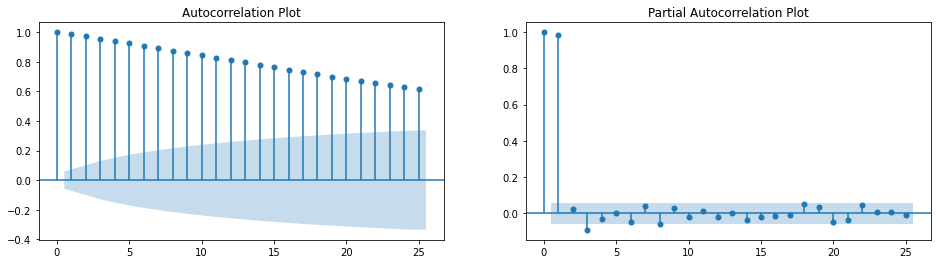

<Figure size 864x576 with 0 Axes>

In [87]:
ACF_PACF_plots(data['Close'])

- The values for the autocorrelation function are close to 1, exceeding the confidence interval, suggesting that they are statistically significant, being the time series is not stationary. For the time series to be stationary, the lags should have been statistically insignificant, lying inside the confidence interval.
- The partial autocorrelation for the first two lags is statistically significant. However, the remaining values are very low.

# Differencing

While the assumption of having stationary data is needed for fitting traditional models, the reality is different, as in many cases data will be non-stationary. A non-stationary series can be transformed in a stationary one through differencing, meaning that the differences between consecutive observations will be computed. This helps with stabilizing the mean, while logarithm transformations help in terms of variance (Hyndman). When differencing, it is important to keep in mind that the resulting series might still be non-stationary, and might require a second differencing. One of the previous unit root tests should be used for assessing the stationarity of the resulted series.

## Differencing Once

Text(0.5, 1.0, 'Autocorrelation Plot')

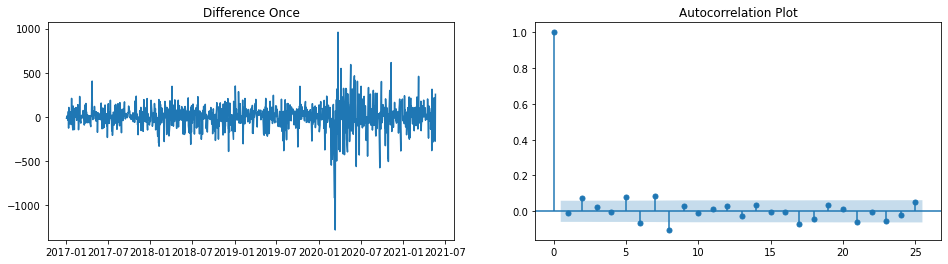

In [88]:
diff = data['Close'].diff().dropna()
fig, (fig1, fig2) = plt.subplots(1,2, figsize=(16,4))
fig1.plot(diff)
fig1.set_title('Difference Once')
plot_acf(diff, lags=25, ax = fig2)
fig2.set_title('Autocorrelation Plot')

## Differencing twice

Text(0.5, 1.0, 'Autocorrelation Plot')

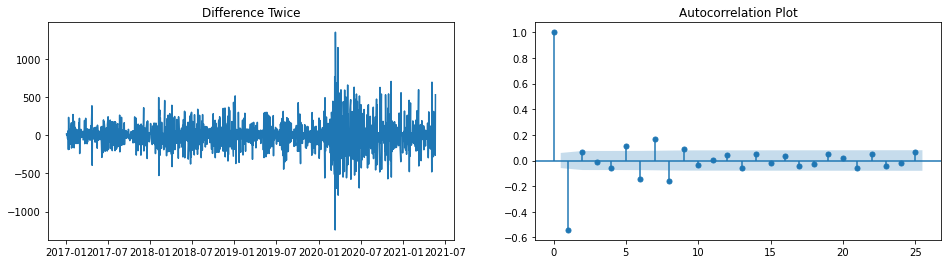

In [89]:
diff2 = diff.diff().dropna()
fig, (fig1, fig2) = plt.subplots(1,2, figsize=(16,4))
fig1.plot(diff2)
fig1.set_title('Difference Twice')
plot_acf(diff2, lags=25, ax = fig2)
fig2.set_title('Autocorrelation Plot')

As the data is not becoming more stationary after the second differencing, we will work with the first difference of the series.

In [90]:
ADF_test(diff)
print("****************************************")
PP_test(diff)
print("****************************************")
KPSS_test(diff)

   Augmented Dickey-Fuller Results   
Test Statistic                -13.062
P-value                         0.000
Lags                                5
-------------------------------------

Trend: Constant and Linear Time Trend
Critical Values: -3.97 (1%), -3.41 (5%), -3.13 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.
****************************************
     Phillips-Perron Test (Z-tau)    
Test Statistic                -33.627
P-value                         0.000
Lags                               12
-------------------------------------

Trend: Constant and Linear Time Trend
Critical Values: -3.97 (1%), -3.41 (5%), -3.13 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.
****************************************
    KPSS Stationarity Test Results   
Test Statistic                  0.051
P-value                         0.565
Lags                  

Testing if the differenced series is stationary, we come to the following conclusions:
- As in the case of the ADF and PP tests, the p-value is much smaller than 0.05 for a 5% significance level, as there is not enough evidence to accept the null hypothesis, therefore the process is stationary.
- In the case of the KPSS test, the Test Statistic value is smaller than the asymptotic critical values, one has not enough evidence to reject the null hypothesis, concluding that the series is stationary.

# Choosing the orders for the AR, MA, ARMA and ARIMA models
## d - order of integration (I(d))
- the number of differences needed to make the series stationary

The order of integration will be 1.

In [91]:
#Verification
print("The d term for the ARIMA model is: ",ndiffs(data['Close'], test="adf"))

The d term for the ARIMA model is:  1


# p -  the order of the Auto Regressive term (AR(p))
- refers to the number of lags to be used as predictors
- found by inspecting the PACF plot

Text(0.5, 1.0, 'Partial Autocorrelation Plot')

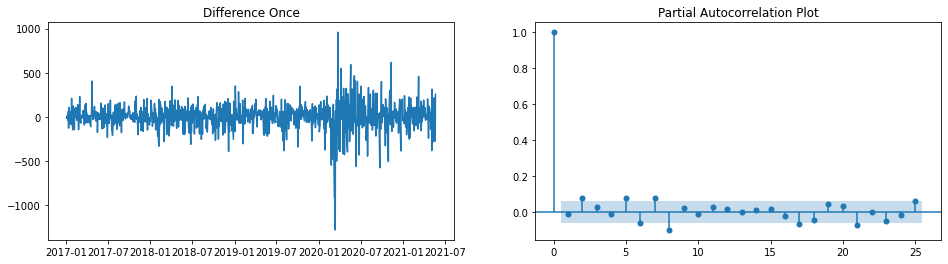

In [92]:
fig, (fig1, fig2) = plt.subplots(1,2, figsize=(16,4))
fig1.plot(diff)
fig1.set_title('Difference Once')
plot_pacf(diff, lags=25, ax = fig2)
fig2.set_title('Partial Autocorrelation Plot')

It can be observed that the PACF lag 8 is significant as it goes out of the confidence interval, therefore p=8 will be chosen as the first model trial.

# q - the order of the Moving Average term (MA(q))
- refers to the number of lagged forecast errors that should go into the ARIMA model
- found by inspecting the ACF plot

Text(0.5, 1.0, 'Autocorrelation Plot')

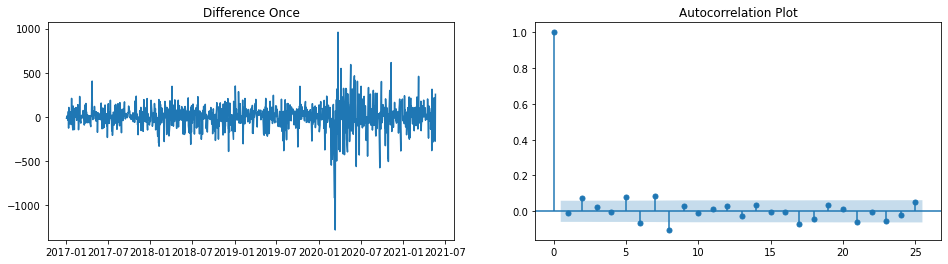

In [93]:
fig, (fig1, fig2) = plt.subplots(1,2, figsize=(16,4))
fig1.plot(diff)
fig1.set_title('Difference Once')
plot_acf(diff, lags=25, ax = fig2)
fig2.set_title('Autocorrelation Plot')

It can be observed that the ACF lag 8 is significant as it goes out of the confidence interval, therefore q=8 will be chosen as the initial q order of the MA model.

# Models

In [94]:
def arma_model(data,p,q):
    model=ARMA(data,order=(p,q))
    model_fit = model.fit()
    print('RMSE: '+str(sqrt(mean_squared_error(data, model_fit.fittedvalues))))
    print('MSE: '+str(mean_squared_error(data, model_fit.fittedvalues)))
    print(model_fit.summary())
    model_residuals = model_fit.resid
    fig, (fig1, fig2) = plt.subplots(1,2, figsize=(16,4))
    model_fit.plot_predict(start=900,end=1115,dynamic=False,ax = fig1)
    fig2.hist(model_residuals)
    fig1.set_title('Prediction')
    fig2.set_title('Distribution of the Residuals')
    lb_test(model_fit)
    gq_test(model_fit)
    sw_test(model_fit)
    residual_stats(model_residuals)
    forecast = model_fit.forecast()[0]
    print('Arma Forecast: %f' % forecast)
    actual_forecast = last_value + forecast
    print('Forecast: %f' % actual_forecast)
    print("Actual:", actual_day_data['Close'].iloc[:1])

In [95]:
def arima_model(data,p,d,q):
    model=ARIMA(data,order=(p,d,q))
    model_fit = model.fit()
    print('RMSE: '+str(sqrt(mean_squared_error(data.iloc[1:], model_fit.fittedvalues))))
    print('MSE: '+str(mean_squared_error(data.iloc[1:], model_fit.fittedvalues)))
    print(model_fit.summary())
    model_residuals = model_fit.resid
    model_fit.plot_predict(start=900,end=1115,dynamic=False)
    lb_test(model_fit)
    gq_test(model_fit)
    sw_test(model_fit)
    residual_stats(model_residuals)
    forecast = model_fit.forecast()[0]
    print('Forecast: %f' % forecast)
    print("Actual:", actual_day_data['Close'].iloc[:1])

In [96]:
def gq_test(model):
    gq_test = pd.DataFrame(sms.het_goldfeldquandt(model.resid, model.model.exog)[:-1],
                           columns=['value'],
                           index=['F statistic', 'p-value'])
    print('\n---------------------\n')
    print(' Goldfeld-Quandt test ')
    print('\n---------------------\n')
    print(gq_test)

In [97]:
def lb_test(model_fit):
    lb_test=sm.stats.acorr_ljungbox(model_fit.resid, lags=[10], return_df=True) # testing to see if the residuals are white noise
    print('\n---------------------\n')
    print(' Ljung-Box test ')
    print('\n---------------------\n')
    print(lb_test)

In [327]:
def residual_stats(model_residuals):
    print('\n---------------------\n')
    print("Summary Statistics of the Residuals")
    print('\n---------------------\n')
    print(model_residuals.describe())
    print('\n---------------------\n')

In [328]:
# Shapiro-Wilk Test for Normality
def sw_test(model_fit):
    stat, p = shapiro(model_fit.resid)
    print('\n---------------------\n')
    print(' Shapiro-Wilk test ')
    print('\n---------------------\n')
    print('Statistics=%.3f, p=%.3f' % (stat, p))
    alpha = 0.05
    if p > alpha:
        print('The residuals looks Gaussian (fail to reject H0)')
    else:
        print('The residuals do not look Gaussian (reject H0)')
    print('\n---------------------\n')

# AR (Example without fitting all models)

RMSE: 145.26665119736347
MSE: 21102.39995009646
                              ARMA Model Results                              
Dep. Variable:                  Close   No. Observations:                 1104
Model:                     ARMA(1, 0)   Log Likelihood               -7062.851
Method:                       css-mle   S.D. of innovations            145.267
Date:                Mon, 31 May 2021   AIC                          14131.701
Time:                        15:56:11   BIC                          14146.721
Sample:                             0   HQIC                         14137.382
                                                                              
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           3.4144      4.325      0.789      0.430      -5.062      11.891
ar.L1.Close    -0.0109      0.030     -0.362      0.717      -0.070       0.048


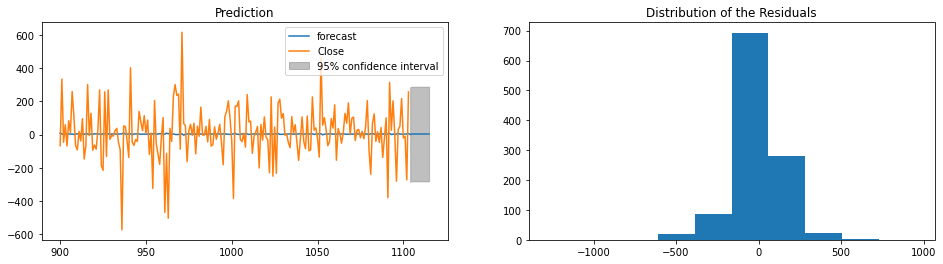

In [329]:
arma_model(diff,1,0)

Characteristics of the AR(1) coefficients:
- the constant is not statistically significant
- the first coefficient of the autoregressive model is statistically significant

The Ljung-Box test is a statistical test that checks if autocorrelation exists in a time series.
It uses the following hypotheses:
- The null hypothesis assumes that the residuals are independently distributed and a p-value below 0.05 indicates that the null hypothesis should be rejected in favour of the alternative one, that being that the residuals exhibit serial correlation.
### Because the p-value of the Ljung-Box test is much smaller than 0.05, there is not enough evidence to accept the null hypothesis, therefore the residuals are not independently distributed (the residuals are not white noise).

The Goldfeld-Quandt test refers to the homoskedasticity of the residuals. When residuals do not have constant variance (they exhibit heteroscedasticity), it is difficult to determine the true standard deviation of the forecast errors, usually resulting in confidence intervals that are too wide/narrow.
- The null hypothesis assumes homoskedasticity and a p-value below 0.05 indicates that the null hypothesis should be rejected in favour of heteroskedasticity
### Because the p-value of the Goldfeld-Quandt test is much smaller than 0.05, there is not enough evidence to accept the null hypothesis, therefore the residuals are heteroskedastic

# MA (Example without fitting all models)

RMSE: 145.26780320006156
MSE: 21102.734646571815
                              ARMA Model Results                              
Dep. Variable:                  Close   No. Observations:                 1104
Model:                     ARMA(0, 1)   Log Likelihood               -7062.859
Method:                       css-mle   S.D. of innovations            145.268
Date:                Mon, 31 May 2021   AIC                          14131.719
Time:                        15:56:23   BIC                          14146.739
Sample:                             0   HQIC                         14137.400
                                                                              
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           3.4166      4.331      0.789      0.430      -5.072      11.905
ma.L1.Close    -0.0095      0.028     -0.337      0.736      -0.064       0.045

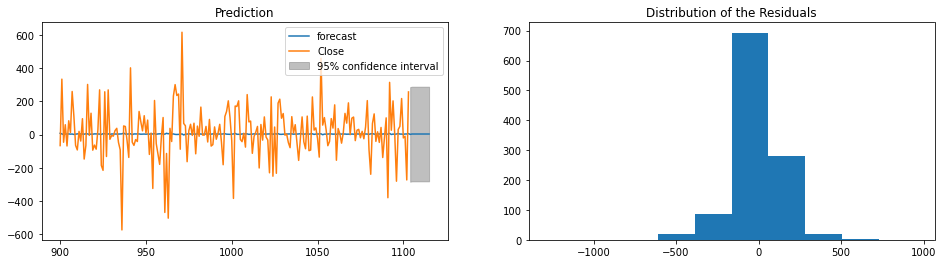

In [337]:
arma_model(diff,0,1)

# ARMA (Example without fitting all models)

RMSE: 145.20666630645047
MSE: 21084.975939832857
                              ARMA Model Results                              
Dep. Variable:                  Close   No. Observations:                 1104
Model:                     ARMA(1, 1)   Log Likelihood               -7062.395
Method:                       css-mle   S.D. of innovations            145.207
Date:                Mon, 31 May 2021   AIC                          14132.790
Time:                        15:56:32   BIC                          14152.817
Sample:                             0   HQIC                         14140.365
                                                                              
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           3.4099      4.285      0.796      0.426      -4.988      11.808
ar.L1.Close    -0.4260      0.260     -1.637      0.102      -0.936       0.084

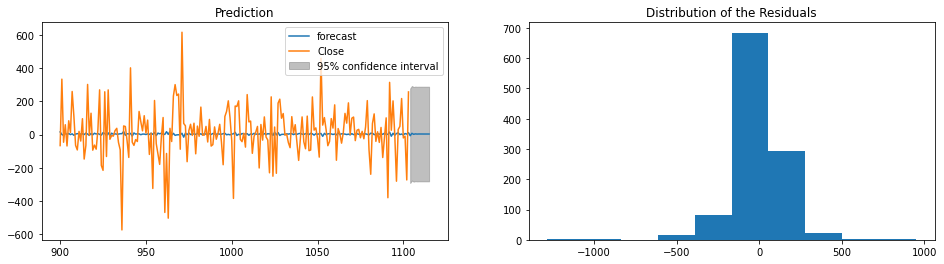

In [345]:
arma_model(diff,1,1)

After fitting all the ARMA models (that have not been included into this notebook for sake of simplicity), the following ones have been chosen for the comparison:

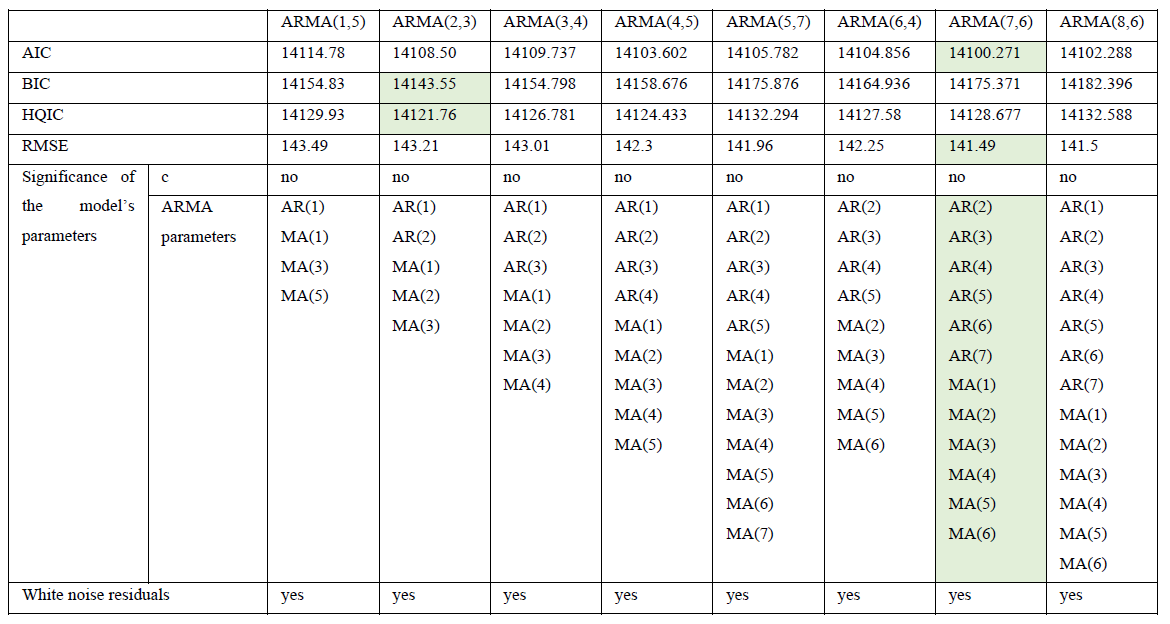

The best fitted model is ARMA(7,6). Even though ARMA(2,3) has the smallest values for BIC and HQIC, the RMSE of the firstly mentioned model is smaller.

RMSE: 12522.849749399275
MSE: 156821765.84602946
                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 1104
Model:                 ARIMA(7, 1, 6)   Log Likelihood               -7035.135
Method:                       css-mle   S.D. of innovations            141.081
Date:                Mon, 31 May 2021   AIC                          14100.271
Time:                        20:28:10   BIC                          14175.371
Sample:                             1   HQIC                         14128.677
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             2.8759      4.694      0.613      0.540      -6.324      12.076
ar.L1.D.Close    -0.2307      0.118     -1.953      0.051      -0.462    

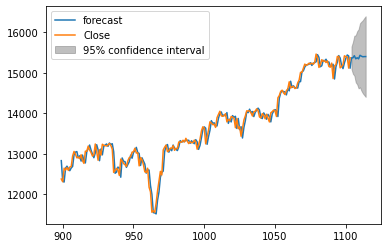

In [418]:
arima_model(data['Close'],7,1,6)

The residuals of the ARIMA(7,6) have been tested upon the following concepts: autocorrelation, homoskedasticity and normality. The model’s residuals are not correlated, therefore they are white noise. In terms of homoskedasticity, the p-value of the Goldfeld-Quandt test is much smaller than 0.05, therefore we reject the null hypothesis, concluding that the residuals are heteroskedastic. Lastly, checking if the residuals are normally distributed has been done. The p-value of the Shapiro-Wilk test is much smaller than 0.05, therefore we reject the null hypothesis, concluding that the residuals are not normally distributed.

# Choosing Two Companies out of the DAX index
##  Bayer and Merck

The time series to be analysed are the Bayer and Merck closing values for the year 2020. In some periods of time, the two series seem to move in the same way, but as the year ends, they take different paths. We will proceed by undergoing a cointegration test, finishing off by fitting the VAR model

In [117]:
data = pd.read_csv('var_data.csv', header = 0, parse_dates=['Date'], index_col='Date')
data

,Bayer,Merck
Date,,
2020-01-02,73.519997,92.040001
2020-01-03,72.580002,91.250000
2020-01-06,71.739998,91.639999
2020-01-07,72.129997,89.199997
2020-01-08,74.000000,88.599998
...,...,...
2020-06-24,67.930000,75.870003
2020-06-25,66.790001,76.570000
2020-06-26,66.900002,75.190002


In [118]:
data_merck = data['Merck']
data_merck


Date
2020-01-02    92.040001
2020-01-03    91.250000
2020-01-06    91.639999
2020-01-07    89.199997
2020-01-08    88.599998
                ...    
2020-06-24    75.870003
2020-06-25    76.570000
2020-06-26    75.190002
2020-06-29    76.120003
2020-06-30    77.330002
Name: Merck, Length: 125, dtype: float64

In [119]:
data_bayer = data['Bayer']
data_merck


Date
2020-01-02    92.040001
2020-01-03    91.250000
2020-01-06    91.639999
2020-01-07    89.199997
2020-01-08    88.599998
                ...    
2020-06-24    75.870003
2020-06-25    76.570000
2020-06-26    75.190002
2020-06-29    76.120003
2020-06-30    77.330002
Name: Merck, Length: 125, dtype: float64

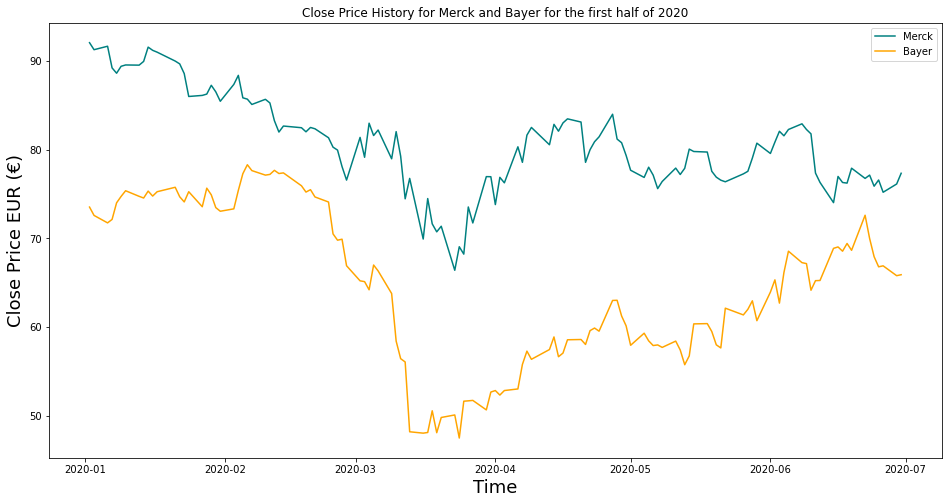

In [120]:
plt.figure(figsize = (16,8))
plt.title('Close Price History for Merck and Bayer for the first half of 2020')
plt.plot(data_merck,color="teal", label='Merck')
plt.plot(data_bayer,color="orange", label = 'Bayer')
plt.xlabel('Time', fontsize=18)
plt.ylabel('Close Price EUR (€)', fontsize=18)
plt.legend(loc='best')
plt.show()

# Cointegration Test

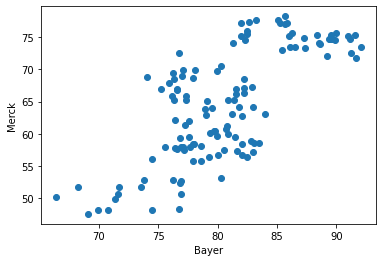

In [121]:
plt.figure(figsize=(6,4))
plt.scatter(data_merck,data_bayer)
plt.xlabel('Bayer')
plt.ylabel('Merck')
plt.show()

The values of the series don't look correlated, but we'll proceed with testing for cointegration

In [122]:
df = pd.concat([data_merck,data_bayer],axis=1)
df.columns=['Merck','Bayer']
df.head()

,Merck,Bayer
Date,,
2020-01-02,92.040001,73.519997
2020-01-03,91.250000,72.580002
2020-01-06,91.639999,71.739998
2020-01-07,89.199997,72.129997
2020-01-08,88.599998,74.000000


In [123]:
import statsmodels.api as sm
model_cointegration = sm.OLS(df.Merck.iloc[:90],df.Bayer.iloc[:90])
model_cointegration = model_cointegration.fit()
model_cointegration.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  Merck   R-squared (uncentered):                   0.990
Model:                            OLS   Adj. R-squared (uncentered):              0.990
Method:                 Least Squares   F-statistic:                              8754.
Date:                Tue, 01 Jun 2021   Prob (F-statistic):                    1.13e-90
Time:                        15:21:54   Log-Likelihood:                         -317.08
No. Observations:                  90   AIC:                                      636.2
Df Residuals:                      89   BIC:                                      638.7
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Bayer          1.2452      0.013     93.561      0.000       1.219       1.272
==============================================================================
Omnibus:                       20.078   Durbin-Watson:                   0.150
Prob(Omnibus):                  0.000   Jarque-Bera (JB):                5.025
Skew:                          -0.157   Prob(JB):                       0.0811
Kurtosis:                       1.886   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

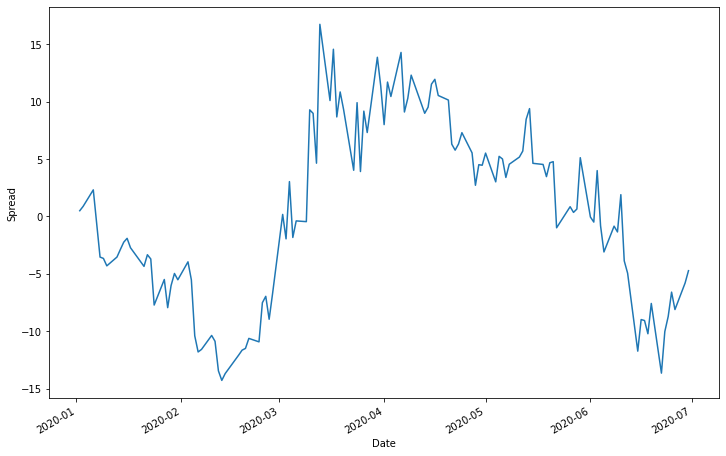

In [124]:
df['spread']=df.Merck - model_cointegration.params[0] * df.Bayer
df.spread.plot(figsize=(12,8))
plt.ylabel('Spread')
plt.show()

The data doesn't look like it's floating around a mean of 0, and that might indicate that the data is not stationary in nature. 

In [125]:
ADF_test(df['spread'].dropna())

   Augmented Dickey-Fuller Results   
Test Statistic                 -1.506
P-value                         0.827
Lags                                5
-------------------------------------

Trend: Constant and Linear Time Trend
Critical Values: -4.04 (1%), -3.45 (5%), -3.15 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


Conclusion: since the p-value of the ADF test is not smaller than 0.05, the two time series are not cointegrated.

# VAR

For fitting the VAR model, the data should be stationary. As the initial data shows a non-stationary behaviour, we will validate this assumption by conducting an ADF test on both time series, for Merck and Bayer closing values.

# Stationarity Check

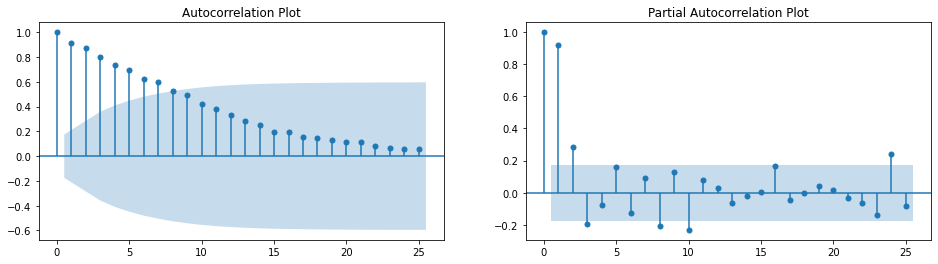

<Figure size 864x576 with 0 Axes>

In [126]:
ACF_PACF_plots(data_merck)

In [127]:
ADF_test(data_merck)
print("****************************************")
PP_test(data_merck)
print("****************************************")
KPSS_test(data_merck)

   Augmented Dickey-Fuller Results   
Test Statistic                 -2.273
P-value                         0.449
Lags                                5
-------------------------------------

Trend: Constant and Linear Time Trend
Critical Values: -4.04 (1%), -3.45 (5%), -3.15 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.
****************************************
     Phillips-Perron Test (Z-tau)    
Test Statistic                 -2.774
P-value                         0.207
Lags                               12
-------------------------------------

Trend: Constant and Linear Time Trend
Critical Values: -4.03 (1%), -3.45 (5%), -3.15 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.
****************************************
    KPSS Stationarity Test Results   
Test Statistic                  0.273
P-value                         0.003
Lags                  

For the ADF and PP tests, the p-value is much higher than 0.05 for a 5% significance level, as there is not enough evidence to reject the null hypothesis, therefore the process contains a unit root (the series is non-stationary).
In the case of the KPSS test, the null hypothesis states the contrary of the previous two methods, that the series is stationary. As the p-value is much smaller than 0.05, one has not enough evidence to accept the null hypothesis, concluding that the series contains a unit root.

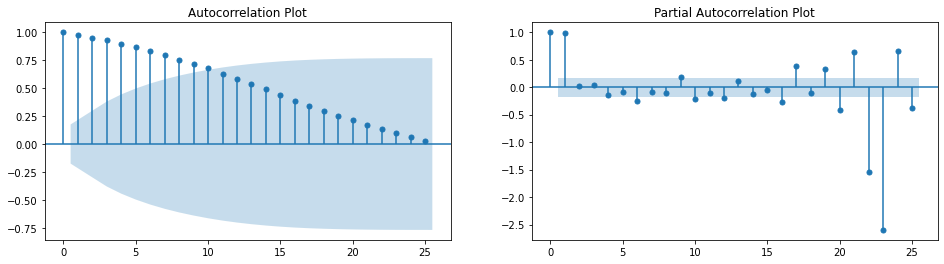

<Figure size 864x576 with 0 Axes>

In [128]:
ACF_PACF_plots(data_bayer)

In [129]:
ADF_test(data_bayer)
print("****************************************")
PP_test(data_bayer)
print("****************************************")
KPSS_test(data_bayer)

   Augmented Dickey-Fuller Results   
Test Statistic                 -1.500
P-value                         0.829
Lags                                5
-------------------------------------

Trend: Constant and Linear Time Trend
Critical Values: -4.04 (1%), -3.45 (5%), -3.15 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.
****************************************
     Phillips-Perron Test (Z-tau)    
Test Statistic                 -1.379
P-value                         0.867
Lags                               12
-------------------------------------

Trend: Constant and Linear Time Trend
Critical Values: -4.03 (1%), -3.45 (5%), -3.15 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.
****************************************
    KPSS Stationarity Test Results   
Test Statistic                  0.353
P-value                         0.001
Lags                  

As both time series are non-stationary, we will transform them by differencing.

In [130]:
diff_merck = data_merck.diff().dropna()
diff_bayer = data_bayer.diff().dropna()
diff_data = data.diff().dropna()

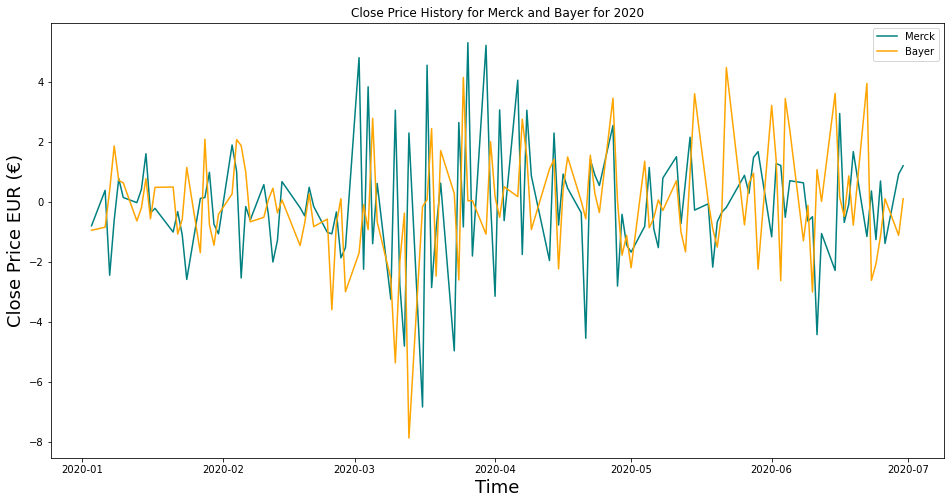

In [131]:
plt.figure(figsize = (16,8))
plt.title('Close Price History for Merck and Bayer for 2020')
plt.plot(diff_merck,color="teal", label='Merck')
plt.plot(diff_bayer,color="orange", label = 'Bayer')
plt.xlabel('Time', fontsize=18)
plt.ylabel('Close Price EUR (€)', fontsize=18)
plt.legend(loc='best')
plt.show()

The result is presented in the graph above. After conducting another ADF test on the series, we validate that the data is ready for fitting the VAR model. Before that, we need to know what would be the best lag for fitting the model, and that is chosen based on the correlation between the Merck and Bayer series for a number of lags.

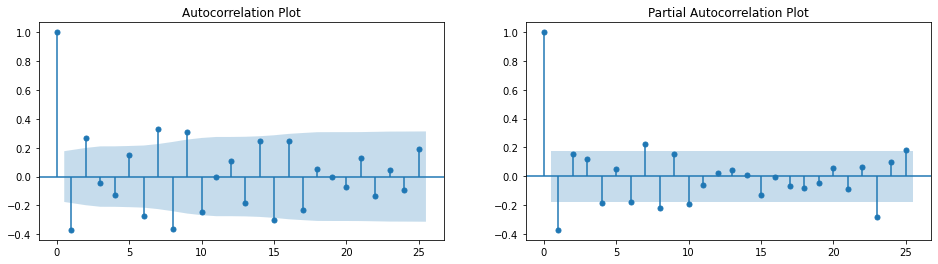

<Figure size 864x576 with 0 Axes>

In [132]:
ACF_PACF_plots(diff_merck)

A significant lag in the PACF is 2, so it will be chosen for the p order of the autoregressive term for the merck time series.

In [133]:
ADF_test(diff_merck)
print("****************************************")
PP_test(diff_merck)
print("****************************************")
KPSS_test(diff_merck)

   Augmented Dickey-Fuller Results   
Test Statistic                 -5.243
P-value                         0.000
Lags                                5
-------------------------------------

Trend: Constant and Linear Time Trend
Critical Values: -4.04 (1%), -3.45 (5%), -3.15 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.
****************************************
     Phillips-Perron Test (Z-tau)    
Test Statistic                -16.118
P-value                         0.000
Lags                               12
-------------------------------------

Trend: Constant and Linear Time Trend
Critical Values: -4.03 (1%), -3.45 (5%), -3.15 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.
****************************************
    KPSS Stationarity Test Results   
Test Statistic                  0.041
P-value                         0.714
Lags                  

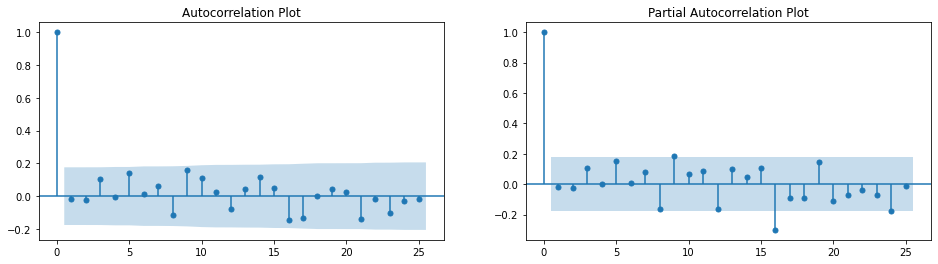

<Figure size 864x576 with 0 Axes>

In [134]:
ACF_PACF_plots(diff_bayer)

The first significant lag in the PACF is 5, so it will be chosen for the p order of the autoregressive term for the bayer time series.

In [135]:
ADF_test(diff_bayer)
print("****************************************")
PP_test(diff_bayer)
print("****************************************")
KPSS_test(diff_bayer)

   Augmented Dickey-Fuller Results   
Test Statistic                 -3.667
P-value                         0.025
Lags                                5
-------------------------------------

Trend: Constant and Linear Time Trend
Critical Values: -4.04 (1%), -3.45 (5%), -3.15 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.
****************************************
     Phillips-Perron Test (Z-tau)    
Test Statistic                -11.331
P-value                         0.000
Lags                               12
-------------------------------------

Trend: Constant and Linear Time Trend
Critical Values: -4.03 (1%), -3.45 (5%), -3.15 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.
****************************************
    KPSS Stationarity Test Results   
Test Statistic                  0.107
P-value                         0.135
Lags                  

After differencing, both data series are stationary.

## Correlation between merck and bayer series

In [136]:
from scipy.stats import pearsonr
for lag in range(1,10):
    merck_series = diff_merck.iloc[lag:]
    lagged_bayer_series = diff_bayer.iloc[:-lag]
    print('Lag: %s'%lag)
    print(pearsonr(merck_series,lagged_bayer_series))
    print('--------------')

Lag: 1
(0.29162813622871403, 0.0010651378532378737)
--------------
Lag: 2
(-0.06707035718293557, 0.4629383519313724)
--------------
Lag: 3
(0.1326090997798988, 0.1470667011273725)
--------------
Lag: 4
(0.061480731329702706, 0.5047275696287041)
--------------
Lag: 5
(-0.1763524146089412, 0.055043013169397574)
--------------
Lag: 6
(0.23306030916256565, 0.011091291170979406)
--------------
Lag: 7
(-0.15664148936280337, 0.09168541006181137)
--------------
Lag: 8
(0.10775918487195654, 0.2495721340777656)
--------------
Lag: 9
(-0.05382975381126911, 0.5677501204128194)
--------------


Lag 6 might be significant when predicting the merck series based on the bayer series, as the p value is much smaller than 0.05.

In [137]:
merck_bayer_data = data[['Merck','Bayer']]

In [138]:
from statsmodels.tsa.api import VAR
model = VAR(merck_bayer_data)

In [139]:
model_fit = model.fit(maxlags=6)
model_fit.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 01, Jun, 2021
Time:                     15:22:00
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    3.01575
Nobs:                     119.000    HQIC:                   2.65511
Log likelihood:          -455.016    FPE:                    11.1372
AIC:                      2.40854    Det(Omega_mle):         9.05156
--------------------------------------------------------------------
Results for equation Merck
              coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------
const            7.351612         3.086521            2.382           0.017
L1.Merck         0.638970         0.096601            6.615           0.000
L1.Bayer         0.263097         0.099279            2.650           0.008
L2.M

The final model is: Mt = 5.92 + 0.68 Mt-1 + 0.18 Bt-1 + 0.39 Mt-2 + 0.16 Mt-5

M - Merck

B - Bayer